In [1]:
import glicko2 as Glicko

In [2]:
# improbable results are likely so set tau low
TAU = 0.2     # system constant
MU = 1500
PHI = 350     # Starting rating deviation
SIGMA = 0.06  # starting volatility

In [3]:
glck = Glicko.Glicko2(mu=MU, tau=TAU, phi=PHI, sigma=SIGMA)

In [4]:
import pandas as pd
import math
import numpy as np

In [5]:
import seaborn as sns

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
naf_data = pd.read_csv("data/NAF_games.csv.gz", sep=",",
                       index_col=None)

In [8]:
naf_data["date"] = pd.to_datetime(
    naf_data.date.apply(lambda y: y.split(" ")[0]),
    format="%d/%m/%Y")

In [9]:
naf_data.set_index("date", inplace=True)

In [10]:
naf_data.sort_index(inplace=True)

In [11]:
# up to June '17 due to errors in data
naf_data = naf_data[:pd.Timestamp('2017-06-01')]

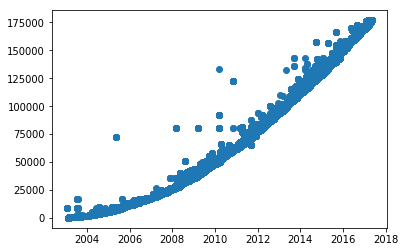

In [12]:
plt.plot(naf_data.gameid, "o")

## Set lookup

In [13]:
home = naf_data[["HomeCoachNAFid", "HomeCoachNAFname"]].drop_duplicates()
away = naf_data[["AwayCoachNAFid", "AwayCoachNAFname"]].drop_duplicates()
away.columns = home.columns

# create lookup table to map id to name
dd = pd.concat([home, away], axis=0)
dd = dd.set_index("HomeCoachNAFid")

lookup = dd.to_dict()["HomeCoachNAFname"]

inv_lookup = {v: k for k, v in lookup.items()}

In [14]:
race_ids = sorted(naf_data.HomeRace.unique())

In [15]:
glck.create_rating()

glicko2.Rating(mu=1500.000, phi=350.000, sigma=0.060)

In [16]:
glck.create_rating(mu=MU, phi=PHI, sigma=SIGMA)

glicko2.Rating(mu=1500.000, phi=350.000, sigma=0.060)

In [17]:
class Player(object):
    
    # need to maintain only historical rankings, not phi etc.
    hist_ratings = None
    
    def __init__(self, player_id, periods):
        
        self.pid = player_id
        self.hist_ratings = pd.DataFrame(
            columns=race_ids, index=periods, dtype=float)
        self.name = lookup[player_id]
        self.rankings = {}
        self.new_rankings = {}
              
    def init_rating(self, race_id, method="median"):
        
        if (method == "default") or (len(self.rankings) < 2):
            
            self.rankings[race_id] = glck.create_rating(
                mu=MU, phi=PHI, sigma=SIGMA)
            
        elif method == "median":
            # other rankings. Possibly exclude stunties? 
            # divide PHI by the number of other ranks?
            # Or always start stunties at 1500?
            mu_vals = [v.mu for v in self.rankings.values()]
            phi_vals = [v.phi for v in self.rankings.values()]
            _mu = np.median(mu_vals)
            _phi = np.max(phi_vals)

            self.rankings[race_id] = glck.create_rating(
                mu=_mu, phi=_phi, sigma=SIGMA)

            if self.pid == 13574:
                print(self.name, mu_vals, mu)

        return self.rankings[race_id]
    
    def end_ranking_period(self, date):
        
        # copy new rankings
        for race in self.hist_ratings.columns:
            if (race in self.rankings) and (race not in self.new_rankings):
                self.rankings[race] = self.decay(race)
            elif race in self.new_rankings:
                self.rankings[race] = self.new_rankings[race]
                
        # delete temp ranks
        self.new_rankings = {}
        
        # fill historical with rankings.
        self.hist_ratings.loc[date] = [self.rate(c) for c in self.hist_ratings.columns]
        
    def rate(self, race):
        
        if race not in self.rankings:
            return np.nan
        
        else:
            q = self.rankings[race]
            return q.mu - 3 * q.phi
        
    def decay(self, race):
        
        # transform into glicko space...
        dnp = glck.scale_down(self.rankings[race])
        
        # increment phi
        phi_star = math.sqrt(min(PHI, dnp.phi ** 2 + dnp.sigma ** 2))
                
        return glck.scale_up(
            glck.create_rating(mu=dnp.mu, phi=phi_star, sigma=dnp.sigma))

In [18]:
cols_home = ["HomeCoachNAFid", "HomeRace", "goalshome"]
cols_away = ["AwayCoachNAFid", "AwayRace", "goalsaway"]

tmp = naf_data[cols_home + cols_away].copy()
tmp2 = naf_data[cols_away + cols_home].copy()

tmp2.columns = tmp.columns

In [19]:
rank_data = pd.concat([tmp, tmp2])

In [20]:
diff = (rank_data.goalshome - rank_data.goalsaway)
win = diff > 0
draw = diff == 0
rank_data["result"] = 0 + (0.5 * draw) + (1.0 * win)

In [21]:
grouped_games = rank_data.groupby(pd.Grouper(freq='M'))

In [22]:
rank_periods = [p for p, _ in grouped_games]

In [23]:
ranking_data = dict()

In [24]:
%%time
for period, x in grouped_games:
    
    if period.month == 1:
        print(period)
        
    for xid in x.HomeCoachNAFid.unique():
        if xid not in ranking_data:
            ranking_data[xid] = Player(xid, rank_periods)
    
    # group by player
    grped = x.groupby(["HomeCoachNAFid", "HomeRace"])
    
    # first run through all players who have played in this period
    for (player, race), data in grped:
        
        player_rank = ranking_data[player]
        
        # if new race
        if race not in player_rank.rankings:
            player_rank.init_rating(race)
            
        series = list()

        for opp_id, opp_race, result in zip(
            data.AwayCoachNAFid, data.AwayRace, data.result):
            
            opp_rank = ranking_data[opp_id]
            
            # opponent ranking?
            if opp_race not in opp_rank.rankings:
                opp_rank.init_rating(opp_race)
            
            series.append(
                (result, opp_rank.rankings[opp_race]))
        
        player_rank.new_rankings[race] = glck.rate(
            player_rank.rankings[race], series)
        
    # end all ranking periods.
    for k, v in ranking_data.items():
        v.end_ranking_period(period)

2004-01-31 00:00:00
2005-01-31 00:00:00
2006-01-31 00:00:00
2007-01-31 00:00:00
2008-01-31 00:00:00
2009-01-31 00:00:00
2010-01-31 00:00:00
2011-01-31 00:00:00
2012-01-31 00:00:00
2013-01-31 00:00:00
2014-01-31 00:00:00
2015-01-31 00:00:00
2016-01-31 00:00:00
2017-01-31 00:00:00
CPU times: user 4min 51s, sys: 452 ms, total: 4min 52s
Wall time: 4min 51s


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
current_ratings = {}

for key, value in ranking_data.items():
    if value.name is np.nan:
        continue
    current_ratings[value.name] = value.hist_ratings.iloc[-1]
    

In [27]:
df_current_ratings = pd.DataFrame(pd.concat(current_ratings, names=["coach", "race"]))
df_current_ratings.columns = ["rating"]

In [28]:
df_current_ratings.rating
df_current_ratings.rating.dropna(inplace=True)

In [29]:
df_current_ratings = df_current_ratings.rating.astype("float")

In [30]:
df_current_ratings = df_current_ratings[~np.isnan(df_current_ratings)]

In [31]:
df_current_ratings = df_current_ratings.sort_values(ascending=False)

In [32]:
inv_lookup["Purplegoo"]

11777

In [33]:
x = ranking_data[inv_lookup["Jimjimany"]]

In [34]:
inv_lookup["Atropabelladonna"]

7084

In [35]:
ranking_data[7084].rankings

{'Chaos Dwarves': glicko2.Rating(mu=2068.539, phi=159.290, sigma=0.060),
 'Norse': glicko2.Rating(mu=1734.871, phi=135.804, sigma=0.060),
 'Orc': glicko2.Rating(mu=1741.652, phi=156.864, sigma=0.060),
 'Underworld': glicko2.Rating(mu=1851.087, phi=120.854, sigma=0.060)}

In [36]:
ranking_data[7084].rankings

{'Chaos Dwarves': glicko2.Rating(mu=2068.539, phi=159.290, sigma=0.060),
 'Norse': glicko2.Rating(mu=1734.871, phi=135.804, sigma=0.060),
 'Orc': glicko2.Rating(mu=1741.652, phi=156.864, sigma=0.060),
 'Underworld': glicko2.Rating(mu=1851.087, phi=120.854, sigma=0.060)}

In [37]:
df_current_ratings[:30]

coach        race         
Pipey        Norse            1675.697555
Jimjimany    Wood Elves       1671.240810
Pipey        Undead           1640.576185
Joemanji     Lizardmen        1640.426444
kfoged       Dark Elves       1632.005536
Joemanji     Undead           1630.099075
delevus      Amazons          1629.101886
Purplegoo    Humans           1626.626071
zoul         Dark Elves       1625.809705
Matt_le_Fou  Amazons          1625.153013
Harti        Dark Elves       1625.032972
Tripleskull  Wood Elves       1624.186244
Dirold       Dark Elves       1622.681231
Phoenix11    Dark Elves       1620.841861
AndyDavo     Dark Elves       1620.402214
Harti        Chaos Dwarves    1617.510951
Spartako     Wood Elves       1617.389887
Tank         Wood Elves       1610.906315
Justicium    Undead           1608.902169
Planlos      Lizardmen        1604.553434
Roller       Dwarves          1602.609648
Pipey        Lizardmen        1601.638418
zahiko       Dark Elves       1601.630387
Podfrey

## Plot historical stats of some players

Issue- need to make mu stickier to slow down changes

Lower volatility?

In [38]:
import seaborn as sns

In [39]:
inv_lookup["Pipey"]

5290

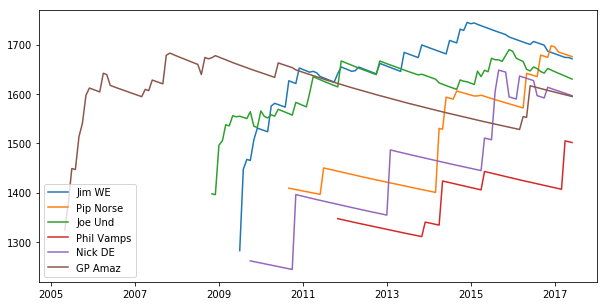

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ranking_data[12403].hist_ratings["Wood Elves"], label="Jim WE")
ax.plot(ranking_data[5290].hist_ratings["Norse"], label="Pip Norse")
ax.plot(ranking_data[3312].hist_ratings["Undead"], label="Joe Und")
ax.plot(ranking_data[11777].hist_ratings["Vampires"], label="Phil Vamps")
ax.plot(ranking_data[13409].hist_ratings["Dark Elves"], label="Nick DE")
ax.plot(ranking_data[149].hist_ratings["Amazons"], label="GP Amaz")
ax.legend(loc=3)

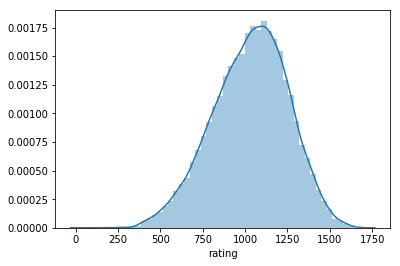

In [41]:
sns.distplot(df_current_ratings)

In [42]:
df_current_ratings.reset_index().iloc[0]

coach      Pipey
race       Norse
rating    1675.7
Name: 0, dtype: object

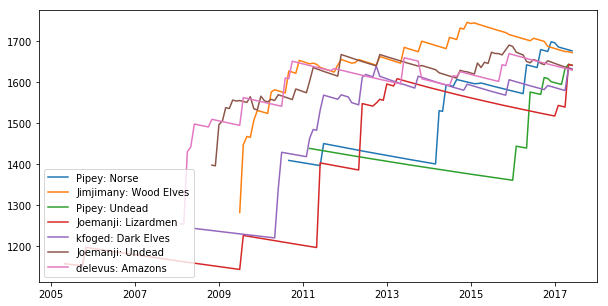

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))

for i in range(7):
    p = df_current_ratings.reset_index().iloc[i]
    pid = inv_lookup[p.coach]
    ax.plot(ranking_data[pid].hist_ratings[p.race], 
            label="{0}: {1}".format(p.coach, p.race))
ax.legend(loc=3)

In [44]:
x = df_current_ratings.reset_index()

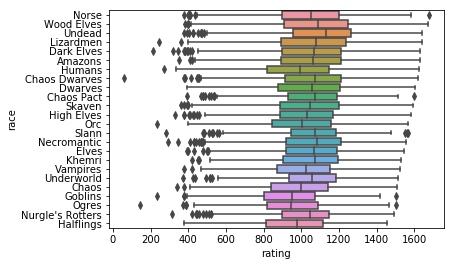

In [45]:
sns.boxplot(y="race", x="rating", data=x)